# Setup

In [2]:
import numpy as np
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft
import math as math
import os
from matplotlib.patches import Polygon
import copy
import pickle
from scipy.stats import norm,wilcoxon,shapiro,ttest_rel
import statistics
from scipy.stats import norm,wilcoxon
from scipy import stats

In [3]:
# plotting parameters
#determine colors and font size|
colors = dict(M='#6600CC',
              F='#000000',
              B='#FFFFFF',
              H='#009900',
              r='#FDB119',
              u='#009900',
              u25='#BBF90F',
              u75='#006400',
              d='#FD6E19',
              #y='#0033FF',  #or 6600CC which is darker and I prefer 
              y='#6600CC',  #or 6600CC which is darker and I prefer 
              N='#0000CC',
              D='#CC0000',
              g='#B1B1B1', #grey
              first5='#B1B1B1',
              last5='#999999',
              BLUE = '#1f77b4',
              ORANGE = '#ff7f0e',
              GREEN = '#2ca02c',
              RED = '#d62728',
              PURPLE = '#9467bd',
              GOLD = '#FDB119') #default colors
              # D = dominant = right; N = nondominant = left

yfill = list(matplotlib.colors.to_rgba(colors['y']))
yfill[-1] = 0.3

ufill = list(matplotlib.colors.to_rgba(colors['u']))
ufill[-1] = 0.3

gfill = list(matplotlib.colors.to_rgba(colors['g']))
gfill[-1] = 0.3

rfill = list(matplotlib.colors.to_rgba(colors['r']))
rfill[-1] = 0.3

bfill = list(matplotlib.colors.to_rgba(colors['BLUE']))
bfill[-1] = 0.3

font = {#'family' : 'normal',
        'weight' : 'ultralight',
        'size'   : 20}
matplotlib.rc('font', **font)
from matplotlib import rcParams
rcParams['axes.titlesize'] = 20
rcParams['font.weight'] = 'ultralight'
rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'cm'

## analysis function

In [4]:
def mean_and_interquartile(data, axis = 0):
    """
    calculate mean and interquartile range of data.
    how to use: 
    mean, quantile25, quantile50, quantile75 = mean_and_interquartile(data, axis)
    """
    mean = np.nanmean(data, axis = axis)
    q25, q50, q75 = np.nanpercentile(data, [25, 50, 75], axis=axis)
    return mean, q25, q50, q75


def WilcoxonTest(all_data):
    """Wilcoxon signed-rank test:  
    tests the null hypothesis that two related paired samples come from the same distribution
    """

    n = len(all_data)
    w = np.zeros(n**2)
    p = np.zeros(n**2)
    sig = np.zeros(n**2)
    flag = []
    k = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                w[k], p[k] = wilcoxon(all_data[i],all_data[j])
                # determine significant (p<=0.05)
                if p[k] <= 0.05:
                    sig[k] = 1
            else: 
                w[k] = np.nan
                p[k] = np.nan
                sig[k] = np.nan #i=j
            
            if sig[k] == 1 and j > i:
                flag.append('there is significant difference between condition '+str(i)+' and condition '+str(j)+', w = '+str(w[k])+ ', pvalue = '+str(p[k]))
            
            k+=1    
    return w,p,sig,flag

## load data

In [5]:
file_folder = "C:\\Users\\amber\\OneDrive - UW\\Sensorimotor Fusion\\pickles\\video_game_analysis\\" # laptop
# file_folder = "" # this folder

file_name = r'time_domain_data_HCPS101_115.pkl' # Amber's CPHS 15 subjects, time domain data
with open(file_folder + file_name, 'rb') as f:
    DATA = pickle.load(f)

file_name = r'time_domain_data_HCPS116_122.pkl' # 7 subject linearity test
with open(file_folder + file_name, 'rb') as f:
    DATA_L = pickle.load(f)

In [6]:
print(DATA.keys())
print(DATA_L.keys())

dict_keys(['subject0', 'subject1', 'subject2', 'subject3', 'subject4', 'subject5', 'subject6', 'subject7', 'subject8', 'subject9', 'subject10', 'subject11', 'subject12', 'subject13', 'subject14'])
dict_keys(['subject0', 'subject1', 'subject2', 'subject3', 'subject4', 'subject5', 'subject6'])


In [7]:
print(DATA['subject0'].keys())
print(DATA_L['subject0'].keys())

print(DATA['subject0']['condition0'].keys())
print(DATA_L['subject0']['condition0'].keys())

# condition0: slider only
# condition1: EMG only

# r = reference position
# d = disturbance
# y = cursor position
# u = emg input

dict_keys(['condition0', 'condition1', 'condition2', 'condition3', 'condition4', 'condition5', 'condition6'])
dict_keys(['condition0', 'condition1', 'condition2', 'condition3', 'condition4'])
dict_keys(['Md', 'r', 'y', 'd', 'Wr', 'u', 'u0', 'u1'])
dict_keys(['Md', 'r', 'y', 'd', 'Wr', 'u', 'u0', 'u1'])


In [8]:
subject_num = len(DATA)
print(subject_num)

condition_num = 2 # here we only look at the first 2 conditions

trial_num = len(DATA['subject0']['condition0']['r'])
print(trial_num)

trial_num_L = len(DATA_L['subject0']['condition0']['r'])
print(trial_num_L)

15
10
4


## pulling specific subjects 

In [9]:
subjects_to_pull = ['subject4', 'subject11','subject14'] # from the first dictionary
subjects_to_pull_L = ['subject0', 'subject1','subject2','subject3','subject4','subject5','subject6'] # from the second dictionary
len(subjects_to_pull), len(subjects_to_pull_L)

(3, 7)

In [10]:
DATA_new = {'subject0':DATA.get(subjects_to_pull[0]), 
            'subject1':DATA.get(subjects_to_pull[1]),
            'subject2':DATA.get(subjects_to_pull[2]),
            'subject3':DATA_L.get(subjects_to_pull_L[0]),
            'subject4':DATA_L.get(subjects_to_pull_L[1]),
            'subject5':DATA_L.get(subjects_to_pull_L[2]),
            'subject6':DATA_L.get(subjects_to_pull_L[3]),
            'subject7':DATA_L.get(subjects_to_pull_L[4]),
            'subject8':DATA_L.get(subjects_to_pull_L[5]),
            'subject9':DATA_L.get(subjects_to_pull_L[6])}
# DATA_new.update(DATA.get(subjects_to_pull[1]))
# DATA_new.update(DATA.get(subjects_to_pull[2]))
DATA_new.keys()

dict_keys(['subject0', 'subject1', 'subject2', 'subject3', 'subject4', 'subject5', 'subject6', 'subject7', 'subject8', 'subject9'])

In [11]:
subject_num = len(DATA_new)
subject_num

10

# Time domain task performance

## one example trial

In [12]:
fs = 60         # sampling rate (Hz)
t0 = 1/fs       # first time step
T = 40          # total duration (s)
time = np.arange(t0, t0+T, 1/fs) # timestamps
N = len(time)   # number of samples
print(time)
print(N)

[1.66666667e-02 3.33333333e-02 5.00000000e-02 ... 3.99666667e+01
 3.99833333e+01 4.00000000e+01]
2400


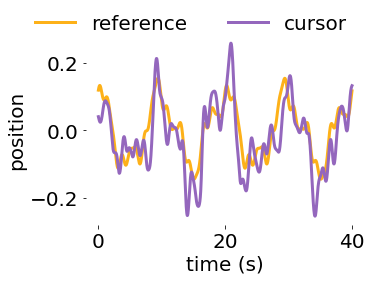

In [13]:
# one example trial of the slider task
iK = 8 # subject
iC = 1 # condition 
iT = -1 # trial
ref = np.asarray(DATA_new['subject'+str(iK)]['condition'+str(iC)]['r'])[iT]
cursor = np.asarray(DATA_new['subject'+str(iK)]['condition'+str(iC)]['y'])[iT]

fig, ax = plt.subplots(figsize=(5, 3.5))
ax.plot(time, ref, label='reference', color = colors['GOLD'],linewidth = 3)
ax.plot(time, cursor, label='cursor', color = colors['PURPLE'],linewidth = 3)
ax.legend(bbox_to_anchor = (1,1.2),ncol = 2,frameon = False)
ax.set_xlabel('time (s)')
ax.set_ylabel('position')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

## average task error and MSE task error

In [14]:
# avergae time domain error over time per condition per subject, averaged across all trials
avg_task_performance = np.empty((subject_num, condition_num, N)) 
# MSE of the time domain error per condition per subject, averaged across trials
MSE_task_performance = np.empty((subject_num, condition_num)) 
for iK in range(subject_num):
    for iC in range(condition_num):
        r = np.asarray(DATA_new['subject'+str(iK)]['condition'+str(iC)]['r']) # reference
        y = np.asarray(DATA_new['subject'+str(iK)]['condition'+str(iC)]['y']) # cursor
        e = np.abs(r - y) # time domain error of each trial
        mse = np.mean(e**2,axis = 1)  # mean squared error of each trial (one number per trial)
        avg_task_performance[iK,iC,:] = np.mean( e ,axis=0) # average across trials
        MSE_task_performance[iK,iC] = np.mean(mse) # average across trials
print(avg_task_performance.shape) # 10 subject x 2 condition (slider, emg) x time
print(MSE_task_performance.shape) # 10 subject x 2 condition (slider, emg)

(10, 2, 2400)
(10, 2)


No handles with labels found to put in legend.


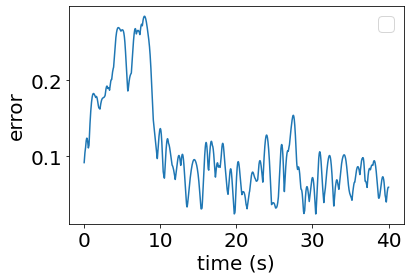

In [15]:
iK = 8 # subject
iC = 0 # condition 
plt.plot(time, avg_task_performance[iK,iC,:])
plt.xlabel('time (s)')
plt.ylabel('error')
plt.legend()
plt.show()

## distribution of time domain error (avg of all trials)

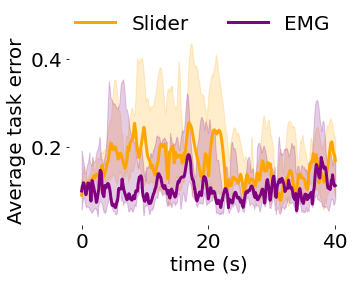

In [16]:
condtion_labels = ['Slider','EMG']
condition_colors = ['orange','purple']
# condition_colors = ['blue','green']
fig, ax = plt.subplots(figsize=(5, 3.5))
for iC in [0,1]: # condition
    mean, quantile25, quantile50, quantile75 = mean_and_interquartile(avg_task_performance[:,iC,:], axis = 0) # distribution across subjects

    ax.plot(time, quantile50,label = condtion_labels[iC], color = condition_colors[iC],linewidth = 3) # median, interquartiles
    ax.fill_between(time, quantile25, quantile75, alpha=0.2, color = condition_colors[iC])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Average task error')
ax.legend(ncol =2 , frameon = False, bbox_to_anchor = (1,1.2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()   

## MSE of time domain error

In [17]:
MSE_task_performance.shape # 10 subject x 2 condition (slider, emg)

(10, 2)

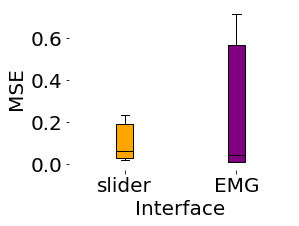

In [18]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize = (4,3))

# Combine the data from both matrices into a single list 
combined_data = [MSE_task_performance[:,0], MSE_task_performance[:,1]]

# Create the box plot with two boxes for the two matrices
matrix_labels = ['slider','EMG']
box = ax.boxplot(combined_data, labels=matrix_labels, patch_artist=True, showfliers=False)

# Set the fill color and median line color for each box
# box_colors = ['darkblue', 'blue','lightblue']
# box_colors = ['#458B74', '#66CDAA','#7FFFD4']
box_colors = ['orange','purple']
median_line_color = 'black'

for i, (patch, color) in enumerate(zip(box['boxes'], box_colors)):
    patch.set_facecolor(color)
    # patch.set_edgecolor('black')  # Set the edge color of the box
    # patch.set_linewidth(1.5)  # Set the line width of the box

    # Find the median line and set its color
    median_line = box['medians'][i]
    median_line.set_color(median_line_color)
    median_line.set_linewidth(1)

# Set the title and labels
# ax.set_title('MSE task error, average across conditions and blocks')
ax.set_ylabel('MSE')
ax.set_xlabel('Interface')
# Set the x-axis ticks and labels
# ax.set_xticks(box_x_positions+1)
ax.set_xticklabels(matrix_labels)
# Show the plot
# Set the title and labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticklabels(matrix_labels)
plt.show()


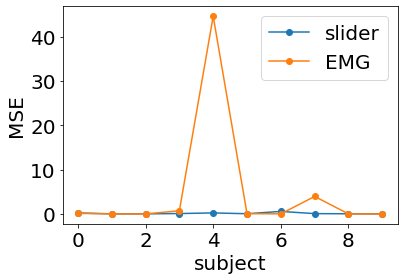

In [19]:
plt.plot(MSE_task_performance[:,0],'-o')
plt.plot(MSE_task_performance[:,1],'-o')
plt.xlabel('subject')
plt.ylabel('MSE')
plt.legend(['slider','EMG'])
# plt.ylim([-0.1,2])
plt.show()

# correlation between MSE and hours of gaming

In [20]:
gaming_hours = np.array([0,0,9,1,0.5,2,0,1.5,20,2]) # hours of gaming per subject

In [21]:
MSE_task_performance[:,0],MSE_task_performance[:,1]

(array([0.2240623 , 0.02146054, 0.02243655, 0.08939555, 0.23071282,
        0.04775822, 0.57011865, 0.07374536, 0.03312134, 0.01516393]),
 array([1.31318211e-01, 1.10080383e-02, 7.12645752e-03, 7.13747462e-01,
        4.46574249e+01, 6.03655861e-02, 2.12497334e-02, 3.95241354e+00,
        6.74038744e-03, 5.63767900e-03]))

R^2=0.123198
R^2=0.034731


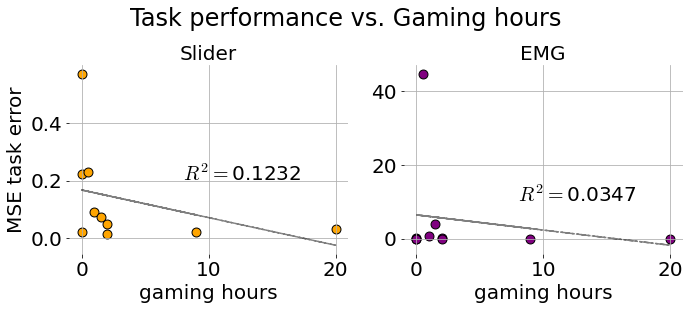

In [22]:
fig, axs = plt.subplots(1,2, figsize = (10,4.5))
fig.suptitle('Task performance vs. Gaming hours')
ax = axs[0]
ax.scatter(gaming_hours,MSE_task_performance[:,0],color ='orange',s = 80, edgecolors='black')
ax.set_xlabel('gaming hours')
ax.set_ylabel('MSE task error')
ax.set_title('Slider')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

stat_x = gaming_hours     
stat_y = MSE_task_performance[:,0]
res = stats.linregress(stat_x,stat_y)
print(f"R^2={(res.rvalue**2):.6f}")
ax.plot(stat_x, res.intercept + res.slope*stat_x,'-.',color = 'black',alpha = 0.5)
ax.text(8,0.2, r'$R^2 = $'+f"{(res.rvalue**2):.4f}", fontsize=20)
ax.grid()

ax = axs[1]
ax.scatter(gaming_hours,MSE_task_performance[:,1],color ='purple',s = 80, edgecolors='black')
ax.set_xlabel('gaming hours')
ax.set_title('EMG')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

stat_x = gaming_hours     
stat_y = MSE_task_performance[:,1]
res = stats.linregress(stat_x,stat_y)
print(f"R^2={(res.rvalue**2):.6f}")
ax.plot(stat_x, res.intercept + res.slope*stat_x,'-.',color = 'black',alpha = 0.5)
ax.text(8,10, r'$R^2 = $'+f"{(res.rvalue**2):.4f}", fontsize=20)
ax.grid()

fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.show()

# Game devices (interface type)

In [65]:
gaming_devices_list_all = ["mouse/keyboard","mouse/keyboard", "handheld controller","mobile device", "handheld controller", "touchscreen","mouse/keyboard", "mouse/keyboard", "mouse/keyboard"]
MSE_devices_EMG = np.array([7.12645752e-03, 7.13747462e-01, 7.13747462e-01, 4.46574249e+01, 4.46574249e+01, 6.03655861e-02, 3.95241354e+00, 6.74038744e-03, 5.63767900e-03])
MSE_devices_Slider = np.array([0.02243655, 0.08939555, 0.08939555, 0.23071282, 0.23071282, 0.04775822, 0.07374536, 0.03312134, 0.01516393])

## combine the same devices

In [66]:
import pandas as pd

my_array = np.stack((MSE_devices_EMG,MSE_devices_Slider))
df = pd.DataFrame(my_array, columns =gaming_devices_list_all)
df = df.T
# rename all mobile devices as 'touchscreen'
df.index = df.index.map(lambda x: 'touchscreen' if x in ['mobile device', 'touchscreen'] else x)
df.columns = ['EMG', 'slider']
print(df)

                           EMG    slider
mouse/keyboard        0.007126  0.022437
mouse/keyboard        0.713747  0.089396
handheld controller   0.713747  0.089396
touchscreen          44.657425  0.230713
handheld controller  44.657425  0.230713
touchscreen           0.060366  0.047758
mouse/keyboard        3.952414  0.073745
mouse/keyboard        0.006740  0.033121
mouse/keyboard        0.005638  0.015164


In [69]:
# take the average of the same device group
result_df = df.groupby(df.index).mean().reset_index()
result_df.columns = ['Devices','EMG', 'slider'] 
print(result_df)

               Devices        EMG    slider
0  handheld controller  22.685586  0.160054
1       mouse/keyboard   0.937133  0.046773
2          touchscreen  22.358895  0.139236


In [68]:
# dfT = df.T
# print(dfT)
# mouse = (dfT['mouse/keyboard'].values)[0,:]
# plt.plot(['EMG']*len(mouse),mouse,'o')
# plt.ylim(0,1)

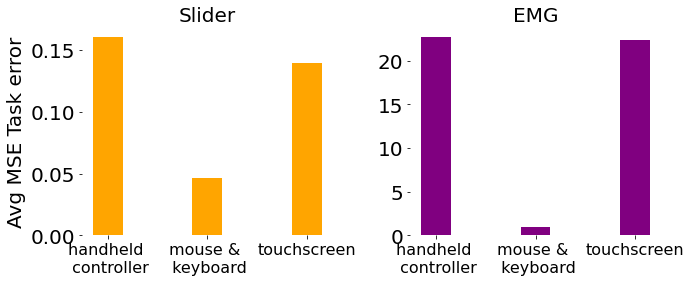

In [71]:
fig, axs = plt.subplots(1,2, figsize = (10,4.5))
# fig.suptitle('Task performance vs. Gaming devices')
device_labels = ['handheld \n controller','mouse & \n keyboard','touchscreen']
ax = axs[0]
bar_width = 0.3
ax.bar(result_df.Devices.values, result_df.slider.values, width=bar_width, color='orange')
ax.set_xticklabels(device_labels,fontsize=16)
# ax.set_xlabel('Devices')
ax.set_ylabel('Avg MSE Task error')
ax.set_title('Slider')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Create the bar plot for the first condition
ax = axs[1]
ax.bar(result_df.Devices.values, result_df.EMG.values, width=bar_width, color='purple')
ax.set_xticklabels(device_labels,fontsize=16)
# ax.set_xlabel('Devices')
ax.set_title('EMG')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.tight_layout()
fig.subplots_adjust(top=0.83)
plt.show()

# barplot for MSE vs hours for slider and emg

In [ ]:
dfT = df.T
print(dfT)

        mouse/keyboard  mouse/keyboard  handheld controller  touchscreen  \
EMG           0.007126        0.713747             0.713747    44.657425   
slider        0.022437        0.089396             0.089396     0.230713   

        handheld controller  touchscreen  mouse/keyboard  mouse/keyboard  \
EMG               44.657425     0.060366        3.952414        0.006740   
slider             0.230713     0.047758        0.073745        0.033121   

        mouse/keyboard  
EMG           0.005638  
slider        0.015164  


In [ ]:
df_all = df.reset_index()
df_all.columns = ['Devices','EMG', 'slider'] # Rename the columns 
df_all

,Devices,EMG,slider
0,mouse/keyboard,0.007126,0.022437
1,mouse/keyboard,0.713747,0.089396
2,handheld controller,0.713747,0.089396
3,touchscreen,44.657425,0.230713
4,handheld controller,44.657425,0.230713
5,touchscreen,0.060366,0.047758
6,mouse/keyboard,3.952414,0.073745
7,mouse/keyboard,0.006740,0.033121
8,mouse/keyboard,0.005638,0.015164


In [ ]:
dfT.groupby(['mouse/keyboard']).count()  

ValueError: Grouper for 'mouse/keyboard' not 1-dimensional

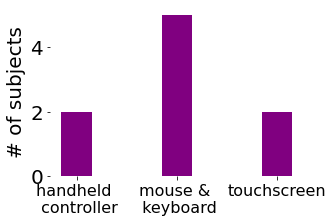

In [ ]:
gaming_devices_combine = np.array(["handheld \n controller", "mouse & \n keyboard","touchscreen"])
frequency_device = [2,5,2]
# Width of each bar
bar_width = 0.3
fig, ax = plt.subplots(figsize = (5,3.5))
# Create the bar plot for the first condition
ax.bar(gaming_devices_combine, frequency_device, width=bar_width, color='purple')
ax.set_xticklabels(gaming_devices_combine,fontsize=16)
# Set labels for the x and y axes
# ax.set_xlabel('Devices')
ax.set_ylabel('# of subjects')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.show()

# frequency of hours barplot

In [28]:
# gave first three all one because i don't have access to this right now
easy_level_EMG = np.array([2, 2, 1, 1, 2, 3, 3, 1, 2, 2])
easy_level_slider = np.array([5, 4, 4, 4, 2, 4, 5, 3, 4, 3])
# Width of each bar
bar_width = 0.35
# Create an array of indices for the x-axis
x = range(len(gaming_hours))

In [29]:
sorted_x, sorted_easy_level_slider = zip(*sorted(zip(x, easy_level_slider)))
sorted_x, sorted_easy_level_EMG = zip(*sorted(zip(x, easy_level_EMG)))

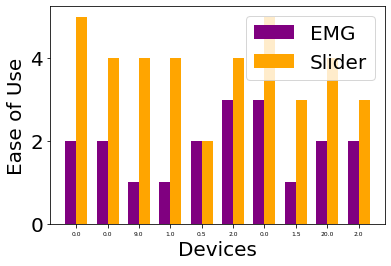

In [30]:
# Create the bar plot for the first condition
plt.bar(sorted_x, sorted_easy_level_EMG, width=bar_width, label='EMG', color='purple')
# Create the bar plot for the second condition
plt.bar([i + bar_width for i in sorted_x], sorted_easy_level_slider, width=bar_width, label='Slider', color='orange')
# Set labels for the x and y axes
plt.xlabel('Devices')
plt.ylabel('Ease of Use')
# Set the x-axis tick positions and labels
plt.xticks([i + bar_width / 2 for i in x], gaming_hours, fontsize = 6)
# Add a legend
plt.legend()

In [31]:
# sorted_easy_level_EMG
sorted_easy_level_EMG, sorted_easy_level_slider

((2, 2, 1, 1, 2, 3, 3, 1, 2, 2), (5, 4, 4, 4, 2, 4, 5, 3, 4, 3))

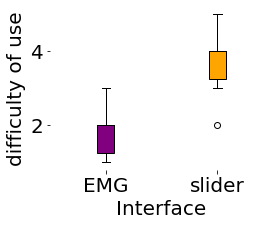

In [32]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize = (4,3))

# Combine the data from both matrices into a single list 
combined_data = [sorted_easy_level_EMG, sorted_easy_level_slider]

# Create the box plot with two boxes for the two matrices
matrix_labels = ['EMG','slider']
box = ax.boxplot(combined_data, labels=matrix_labels, patch_artist=True)

# Set the fill color and median line color for each box
# box_colors = ['darkblue', 'blue','lightblue']
# box_colors = ['#458B74', '#66CDAA','#7FFFD4']
box_colors = ['purple','orange']
median_line_color = 'black'

for i, (patch, color) in enumerate(zip(box['boxes'], box_colors)):
    patch.set_facecolor(color)
    # patch.set_edgecolor('black')  # Set the edge color of the box
    # patch.set_linewidth(1.5)  # Set the line width of the box

    # Find the median line and set its color
    median_line = box['medians'][i]
    median_line.set_color(median_line_color)
    median_line.set_linewidth(1)

# Set the title and labels
# ax.set_title('MSE task error, average across conditions and blocks')
ax.set_ylabel(r'difficulty of use')
ax.set_xlabel('Interface')
# Set the x-axis ticks and labels
# ax.set_xticks(box_x_positions+1)
ax.set_xticklabels(matrix_labels)
# Show the plot
# Set the title and labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticklabels(matrix_labels)
plt.show()


# ease of use vs. interfaces

In [33]:
Arrays = np.array([[1, 0.0, 3], # ease of use , hours, number of subjects 
                    [1, 0.0, 3],
                    [1, 9.0, 1],
                    [1, 1.0, 1],
                    [1, 0.5, 1],
                    [2, 2.0, 2],
                    [3, 0.0, 3],
                    [1, 1.5, 1],
                    [2, 20.0, 1],
                    [2, 2.0, 2]])
df = pd.DataFrame(Arrays, columns =["difficulty","hours", "frequency"])
df

,difficulty,hours,frequency
0,1.0,0.0,3.0
1,1.0,0.0,3.0
2,1.0,9.0,1.0
3,1.0,1.0,1.0
4,1.0,0.5,1.0
5,2.0,2.0,2.0
6,3.0,0.0,3.0
7,1.0,1.5,1.0
8,2.0,20.0,1.0
9,2.0,2.0,2.0


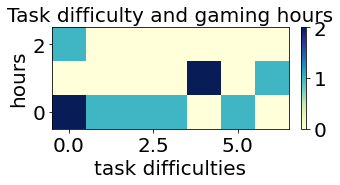

In [34]:
# Create a DataFrame with 10 subjects

# Create a pivot table to count the frequency of each combination
pivot_table = df.pivot_table(index='difficulty', columns='hours', aggfunc='size', fill_value=0)

# Create a heatmap
fig,ax = plt.subplots(figsize=(5,4.5))
im1 = ax.imshow(pivot_table, cmap="YlGnBu",origin='lower')

ax.set_title('Task difficulty and gaming hours')
ax.set_xlabel('task difficulties')
ax.set_ylabel('hours')
fig.colorbar(im1,ticks=np.linspace(0, 2, 3),fraction=0.02, pad=0.05)  # Add a color bar
# ax.grid(color='w', linewidth=2)
plt.tight_layout()
plt.show()

In [35]:
# data_EMG = {"subject 0": [1, 0.0, 3], # ease of use , hours, number of subjects 
#             "subject 1": [1, 0.0, 3],
#             "subject 2": [1, 9.0, 1],
#             "subject 3": [1, 1.0, 1],
#             "subject 4": [1, 0.5, 1],
#             "subject 5": [2, 2.0, 2],
#             "subject 6": [3, 0.0, 3],
#             "subject 7": [1, 1.5, 1],
#             "subject 8": [2, 20.0, 1],
#             "subject 9": [2, 2.0, 2]
# }
# df = pd.DataFrame(data_EMG)

# plt.imshow(df, cmap='YlGnBu')
# plt.xlabel("Subjects")
# plt.ylabel("Difficulty")
# plt.colorbar()  # Add a color bar
# plt.show()

In [58]:
np.arange(1,6)

array([1, 2, 3, 4, 5])

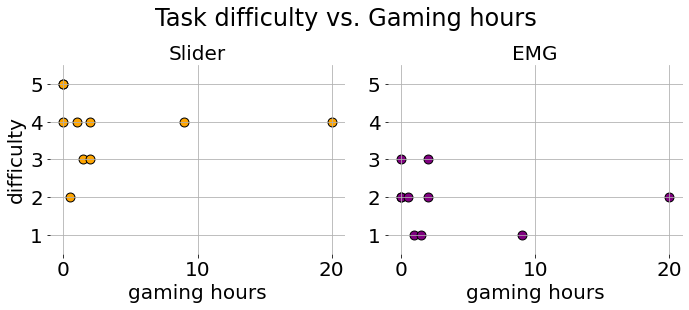

In [64]:
fig, axs = plt.subplots(1,2, figsize = (10,4.5))
fig.suptitle('Task difficulty vs. Gaming hours')
ax = axs[0]
ax.scatter(gaming_hours,sorted_easy_level_slider,color ='orange',s = 80, edgecolors='black')
ax.set_xlabel('gaming hours')
ax.set_ylabel('difficulty')
# ax.set_xlim(0,10)
ax.set_ylim(0.5,5.5)
ax.set_title('Slider')
ax.set_yticks(np.arange(1,6))
ax.set_yticklabels(np.arange(1,6))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid()

ax = axs[1]
ax.scatter(gaming_hours,sorted_easy_level_EMG,color ='purple',s = 80, edgecolors='black')
ax.set_xlabel('gaming hours')
# ax.set_xlim(0,10)
ax.set_ylim(0.5,5.5)
ax.set_yticks(np.arange(1,6))
ax.set_yticklabels(np.arange(1,6))
ax.set_title('EMG')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid()

fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.show()